# Assignment 3: Exploring Tree-Based Regression Methods for 3D Sinusoidal Data
## DTSC 680: Applied Machine Learning

## Name: Kurtis Crowe

## Directions and Overview

The main purpose of this assignment is for you to gain experience using tree-based methods to solve simple regression problems.  In this assignment, you will fit a `Gradient-Boosted Regression Tree`, a `Random Forest`, and a `Decision Tree` to a noisy 3D sinusoidal data set.  Since these models can be trained very quickly on the supplied data, I want you to first manually adjust hyperparameter values and observe their influence on the model's predictions.  That is, you should manually sweep the hyperparameter space and try to hone in on the optimal hyperparameter values, again, _manually_.  (Yep, that means guess-and-check: pick some values, train the model, observe the prediction curve, repeat.)

But wait, there's more! Merely attempting to identify the optimal hyperparameter values is not enough.  Be sure to really get a visceral understanding of how altering a hyperparameter in turn alters the model predictions (i.e. the prediction curve).  This is how you will build your machine learning intuition!

So, play around and build some models.  When you are done playing with hyperparameter values, you should try to set these values to the optimal values manually (you're likely going to be _way_ off).  Then, retrain the model.  Next in this assignment, we will perform several grid searches, so you'll be able to compare your "optimal" hyperparameter values with those computed from the grid search.

We will visualize model predictions for the optimal `Gradient-Boosted Regression Tree`, a `Random Forest`, and `Decision Tree` models that were determined by the grid searches.  Next, you will compute the generalization error on the test set for the three models.

## Preliminaries

Let's import some common packages:

In [17]:
# Common imports
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
import pandas as pd
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import os

# Where to save the figures
PROJECT_ROOT_DIR = "."
FOLDER = "figures"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def plot3Ddata(train_df):
    fig = plt.figure(figsize=(15, 15))
    
    # First subplot
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.scatter3D(train_df['x'], train_df['y'], train_df['z'], c='steelblue')
    ax1.set_xlabel('X', color='maroon', labelpad=10)
    ax1.set_ylabel('Y', color='maroon', labelpad=10)
    ax1.set_zlabel('Z', color='maroon', labelpad=10)
    ax1.view_init(0, 89)
    ax1.set_xlim(0,14)
    ax1.set_yticks([-6,-4,-2,0,2,4,6])

    # Second subplot
    ax2 = fig.add_subplot(222, projection='3d')
    ax2.scatter3D(train_df['x'], train_df['y'], train_df['z'], c='steelblue')
    ax2.set_xlabel('X', color='maroon', labelpad=10)
    ax2.set_ylabel('Y', color='maroon', labelpad=10)
    ax2.set_zlabel('Z', color='maroon', labelpad=10)
    ax2.view_init(50, 0)
    ax2.set_yticks(train_df['y'])
    ax2.set_xlim(0,14)
    ax2.set_yticks([-6,-4,-2,0,2,4,6])
    
    # Third subplot
    ax3 = fig.add_subplot(223, projection='3d')
    ax3.scatter3D(train_df['x'], train_df['y'], train_df['z'], c='steelblue')
    ax3.set_xlabel('X', color='maroon', labelpad=10)
    ax3.set_ylabel('Y', color='maroon', labelpad=10)
    ax3.set_zlabel('Z', color='maroon', labelpad=10)
    ax3.view_init(40, 40)
    ax3.set_xlim(0,14)
    ax3.set_yticks([-6,-4,-2,0,2,4,6])

    # Fourth subplot
    ax4 = fig.add_subplot(224, projection='3d')
    ax4.scatter3D(train_df['x'], train_df['y'], train_df['z'], c='steelblue')
    ax4.set_xlabel('X', color='maroon', labelpad=10)
    ax4.set_ylabel('Y', color='maroon', labelpad=10)
    ax4.set_zlabel('Z', color='maroon', labelpad=10)
    ax4.view_init(30, 20)
    ax4.set_xlim(0,14)
    ax4.set_yticks([-6,-4,-2,0,2,4,6])

    
def plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z):
    fig = plt.figure(figsize=(15, 15))
    
    # First subplot
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.scatter3D(scat_x, scat_y, scat_z, c='steelblue', label='Training Data')
    ax1.plot3D(fit_x, fit_y, fit_z, c='black', label='Model Predictions', alpha=1)
    ax1.set_xlabel('X', color='maroon', labelpad=10)
    ax1.set_ylabel('Y', color='maroon', labelpad=10)
    ax1.set_zlabel('Z', color='maroon', labelpad=10)
    ax1.view_init(0, 89)
    ax1.set_xlim(0, 14)
    ax1.set_yticks([-6, -4, -2, 0, 2, 4, 6])
    ax1.set_title('Plot 1')

    # Second subplot
    ax2 = fig.add_subplot(222, projection='3d')
    ax2.scatter3D(scat_x, scat_y, scat_z, c='steelblue', label='Training Data')
    ax2.plot3D(fit_x, fit_y, fit_z, c='black', label='Model Predictions', alpha=1)
    ax2.set_xlabel('X', color='maroon', labelpad=10)
    ax2.set_ylabel('Y', color='maroon', labelpad=10)
    ax2.set_zlabel('Z', color='maroon', labelpad=10)
    ax2.view_init(50, 0)
    ax2.set_xlim(0, 14)
    ax2.set_yticks([-6, -4, -2, 0, 2, 4, 6])
    ax2.set_title('Plot 2')
    
    # Third subplot
    ax3 = fig.add_subplot(223, projection='3d')
    ax3.scatter3D(scat_x, scat_y, scat_z, c='steelblue', label='Training Data')
    ax3.plot3D(fit_x, fit_y, fit_z, c='black', label='Model Predictions', alpha=1)
    ax3.set_xlabel('X', color='maroon', labelpad=10)
    ax3.set_ylabel('Y', color='maroon', labelpad=10)
    ax3.set_zlabel('Z', color='maroon', labelpad=10)
    ax3.view_init(40, 40)
    ax3.set_xlim(0, 14)
    ax3.set_yticks([-6, -4, -2, 0, 2, 4, 6])
    ax3.set_title('Plot 3')

    # Fourth subplot
    ax4 = fig.add_subplot(224, projection='3d')
    ax4.scatter3D(scat_x, scat_y, scat_z, c='steelblue', label='Training Data')
    ax4.plot3D(fit_x, fit_y, fit_z, c='black', label='Model Predictions', alpha=1)
    ax4.set_xlabel('X', color='maroon', labelpad=10)
    ax4.set_ylabel('Y', color='maroon', labelpad=10)
    ax4.set_zlabel('Z', color='maroon', labelpad=10)
    ax4.view_init(30, 20)
    ax4.set_xlim(0, 14)
    ax4.set_yticks([-6, -4, -2, 0, 2, 4, 6])
    ax4.set_title('Plot 4')
    
    plt.show()


# Import and Split Data

Complete the following:



1. Begin by importing the data from the file called `3DSinusoidal.csv`.  Name the returned DataFrame `data`. 

2. Call [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with a `test_size` of 20%.  `x` and `y` will be your feature data and `z` will be your response data. Save the output into `X_train`, `X_test`, `z_train`, and `z_test`, respectively.  Specify the `random_state` parameter to be `42` (do this throughout the entire note book).

In [18]:
from sklearn.model_selection import train_test_split


#importing data calling it data
data = pd.read_csv('3DSinusoidal.csv')

#splitting the data
X = data[['x', 'y']]
z = data['z']
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)






# Plot Data

Simply plot your training data here, so that you know what you are working with.  You must define a function called `plot3Ddata`, which accepts a Pandas DataFrame (composed of 3 spatial coordinates) and uses `scatter3D()` to plot the data.  Use this function to plot only the training data (recall that you don't even want to look at the test set, until you are ready to calculate the generalization error).  You must place the definition of this function in the existing code cell of the above __Preliminaries__ section, and have nothing other than the function invocation in the below cell. 

You must emulate the graphs shown in the respective sections below. Each of the graphs will have four subplots. Note the various viewing angles that each subplot presents - you can achieve this with the view_init() method. Be sure to label your axes as shown.

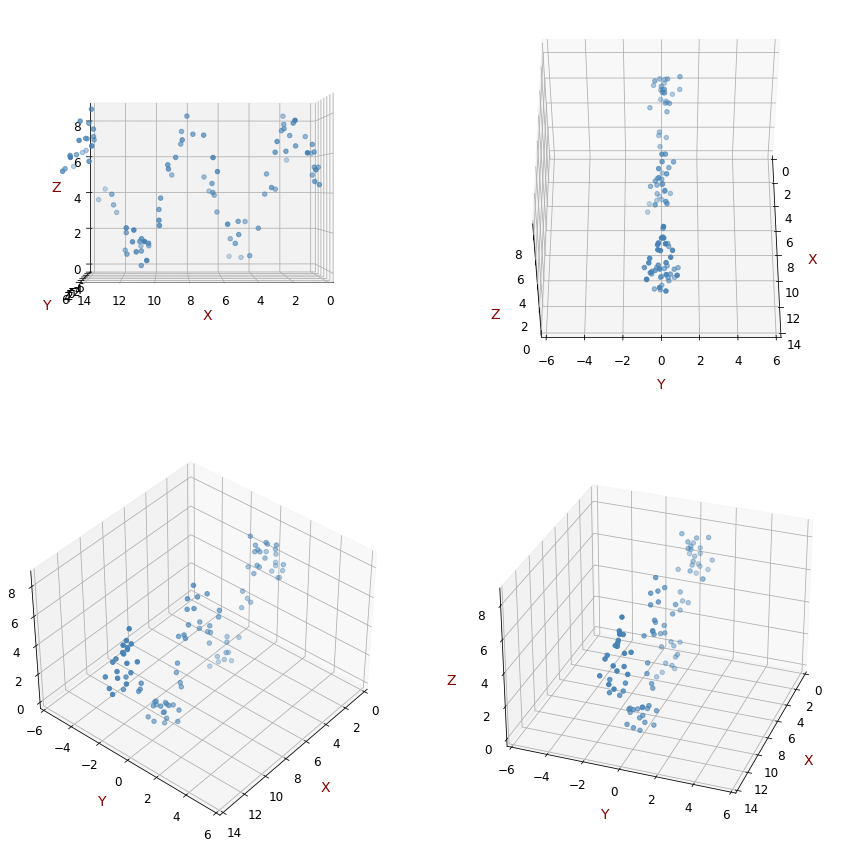

In [19]:
train_df = pd.DataFrame({'x': X_train['x'], 'y': X_train['y'], 'z': z_train})
plot3Ddata(train_df)


## A Quick Note

In the following sections you will be asked to plot the training data along with the model's predictions for that data superimposed on it.  You must write a function called `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` that will plot this figure.  The function accepts six parameters as input, shown in the function signature.  All six input parameters must be NumPy arrays. The Numpy arrays called fit_x and fit_y represent the x and y coordinates from the training data and fit_z represents the model predictions from those coordinates (i.e. the prediction curve). The three Numpy arrays called `scat_x, scat_y,` and  `scat_z` represent the x, y, and z coordinates of the training data.   

You must place the definition of the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function in the existing code cell of the above __Preliminaries__ section. (The function header is already there - you must complete the function definition.)

You will use the `plotscatter3Ddata()` function in each of the below __Plot Model Predictions for Training Set__ portion of the three __Explore 3D Data__ sections, as well as the __Visualize Optimal Model Predictions__ section.

___Important: Below, you will be asked to plot the model's prediction curve along with the training data.  Even if you correctly train the model, you may find that your trendline is very ugly when you first plot it.  If this happens to you, try plotting the model's predictions using a scatter plot rather than a connected line plot.  You should be able to infer the problem and solution with the trendline from examining this new scatter plot of the model's predictions. All of your plots, however, should be connected line plots when submitted. Please refer to the FAQ document for more clarity.___

Note: You must use the supplied data and not np.linspace() to create the prediction curve.

# Explore 3D Data: GradientBoostingRegressor

Fit a `GradientBoostingRegressor` model to this data.  You must manually assign values to the following hyperparameters.  You should "play around" by using different combinations of hyperparameter values to really get a feel for how they affect the model's predictions.  Update the below bullets accordingly.  When you are done playing, set these to the best values you can for submission.  Update the below bullets accordingly.  (It is totally fine if you don't elucidate the optimal values here; however, you will want to make sure your model is not excessively overfitting or underfitting the data.  Do this by examining the prediction curve generated by your model.  You will be graded, more exactly, on the values that you calculate later from performing several rounds of grid searches.)

Values "played around with":
 - `learning_rate = <values>`
 - `max_depth = <values>`
 - `n_estimators = <values>`
 - `random_state = 42`

Initial "best values":
 - `learning_rate = <0.1>`
 - `max_depth = <2>`
 - `n_estimators = <100>`
 - `random_state = 42`

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt =  GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=0.1, random_state=42)
gbrt.fit(X_train,z_train) 

GradientBoostingRegressor(max_depth=2, random_state=42)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

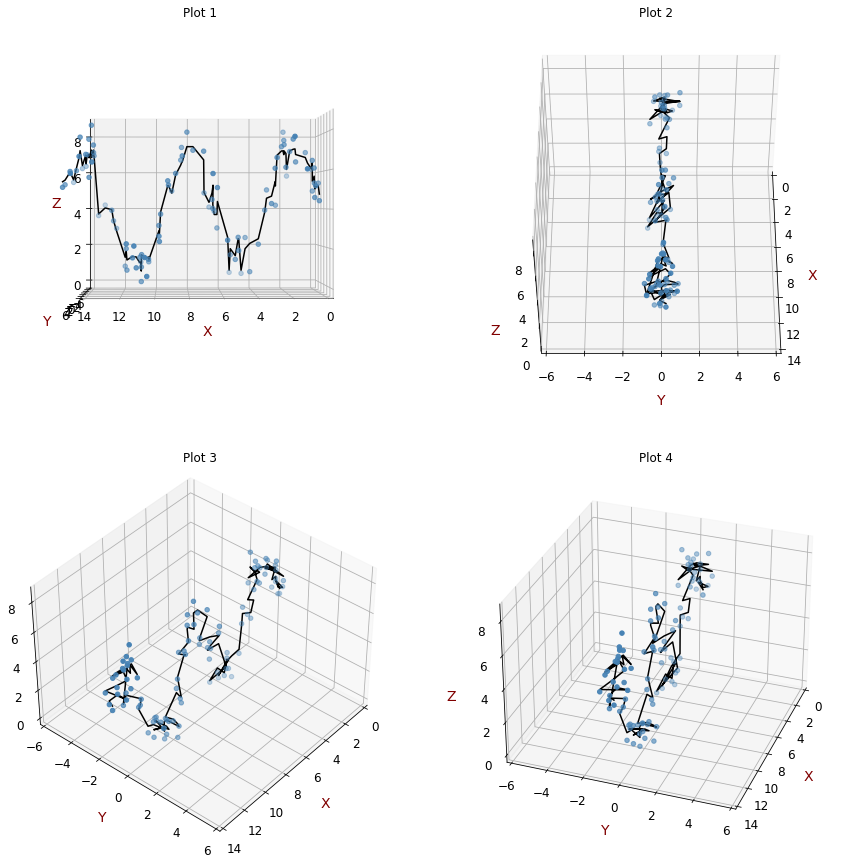

In [21]:
#create predictions with predict()
z_preds = gbrt.predict(X_train)

#create new dataframe to sort
gbrt_sorted = pd.DataFrame({'X' : X_train.iloc[:, 0],
                            'y' : X_train.iloc[:, 1],
                            'z' : z_train,
                            'z_preds' : z_preds})

#sort by X
gbrt_sorted = gbrt_sorted.sort_values(by='X')
gbrt_sorted = gbrt_sorted.reset_index(drop=True)

#convert df to np array
gbrt_sorted_np = gbrt_sorted.values

#plot using our function
plotscatter3Ddata(gbrt_sorted_np[:,0], gbrt_sorted_np[:, 1], gbrt_sorted_np[:,3], gbrt_sorted_np[:,0], gbrt_sorted_np[:, 1], gbrt_sorted_np[:, 2])

# Explore 3D Data: RandomForestRegressor

Fit a `RandomForestRegressor` model to this data.  You must manually assign values to the following hyperparameters.  You should "play around" by using different combinations of hyperparameter values to really get a feel for how they affect the model's predictions.  Update the below bullets accordingly.  When you are done playing, set these to the best values you can for submission.  Update the below bullets accordingly.  (It is totally fine if you don't elucidate the optimal values here; however, you will want to make sure your model is not excessively overfitting or underfitting the data.  Do this by examining the prediction curve generated by your model.  You will be graded, more exactly, on the values that you calculate later from performing several rounds of grid searches.)

Values "played around with":
 - `min_samples_split = <values>`
 - `max_depth = <values>`
 - `n_estimators = <values>`
 - `random_state = 42`

Initial "best values":
 - `min_samples_split = <5>`
 - `max_depth = <5>`
 - `n_estimators = <100>`
 - `random_state = 42`

In [22]:
from sklearn.ensemble import RandomForestRegressor

rfr =  RandomForestRegressor(max_depth=5, n_estimators=100, min_samples_split=5, random_state=42)
rfr.fit(X_train,z_train) 

RandomForestRegressor(max_depth=5, min_samples_split=5, random_state=42)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

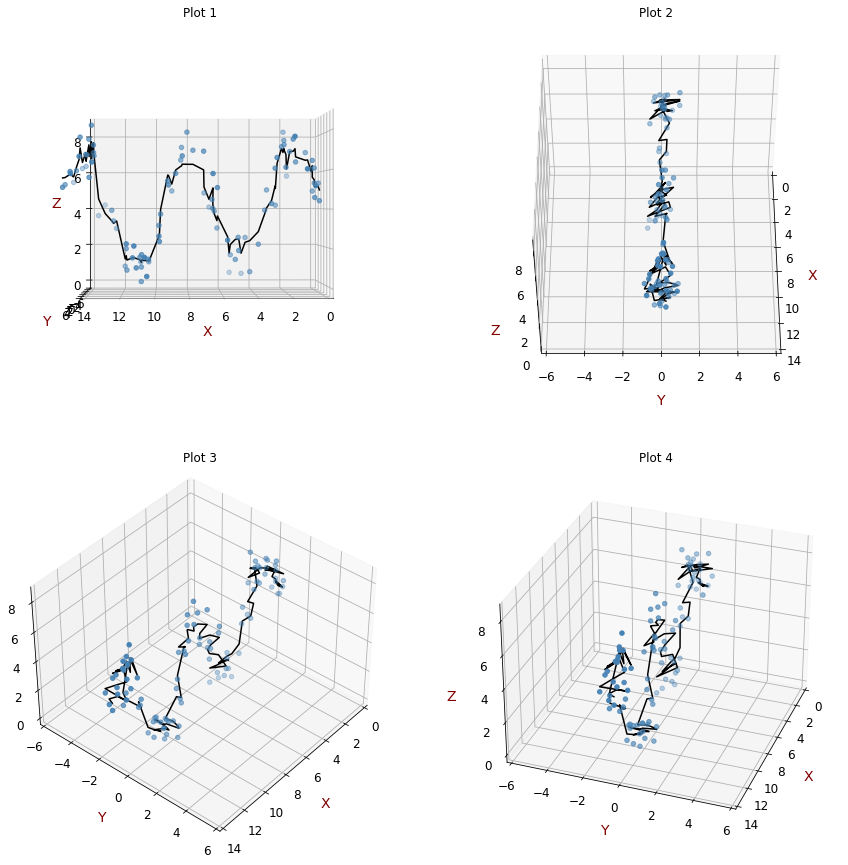

In [23]:
#create predictions with predict()
z_preds2 = rfr.predict(X_train)

#create new dataframe to sort
rfr_sorted = pd.DataFrame({'X' : X_train.iloc[:, 0],
                            'y' : X_train.iloc[:, 1],
                            'z' : z_train,
                            'z_preds' : z_preds2})

#sort by X
rfr_sorted = rfr_sorted.sort_values(by='X')
rfr_sorted = rfr_sorted.reset_index(drop=True)

#convert df to np array
rfr_sorted_np = rfr_sorted.values

#plot using plotscatter3Ddata function and numpy array
plotscatter3Ddata(rfr_sorted_np[:,0], rfr_sorted_np[:, 1], rfr_sorted_np[:,3], rfr_sorted_np[:,0], rfr_sorted_np[:, 1], rfr_sorted_np[:, 2])

# Explore 3D Data: DecisionTreeRegressor

Fit a `DecisionTreeRegressor` model to this data.  You must manually assign values to the following hyperparameters.  You should "play around" by using different combinations of hyperparameter values to really get a feel for how they affect the model's predictions.  Update the below bullets accordingly.  When you are done playing, set these to the best values you can for submission.  Update the below bullets accordingly.  (It is totally fine if you don't elucidate the optimal values here; however, you will want to make sure your model is not excessively overfitting or underfitting the data.  Do this by examining the prediction curve generated by your model.  You will be graded, more exactly, on the values that you calculate later from performing several rounds of grid searches.)

Values "played around with":
 - `splitter = <values>`
 - `max_depth = <values>`
 - `min_samples_split = <values>`
 - `random_state = 42`

Initial "best values":
 - `splitter = <best>`
 - `max_depth = <7>`
 - `min_samples_split = <2>`
 - `random_state = 42`

In [24]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(splitter='best', max_depth=7, min_samples_split=2, random_state=42)


dtr.fit(X_train, z_train)


DecisionTreeRegressor(max_depth=7, random_state=42)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

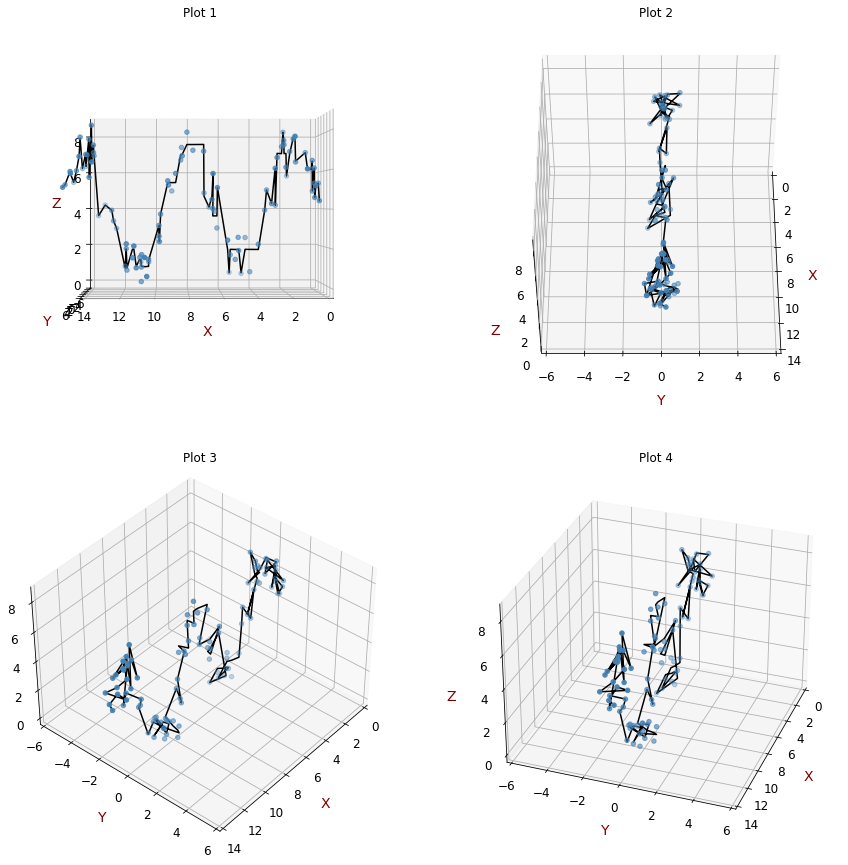

In [25]:
#create predictions with predict()
z_preds3 = dtr.predict(X_train)

#create new dataframe to sort
dtr_sorted = pd.DataFrame({'X' : X_train.iloc[:, 0],
                            'y' : X_train.iloc[:, 1],
                            'z' : z_train,
                            'z_preds' : z_preds3})

#sort by X
dtr_sorted = dtr_sorted.sort_values(by='X')
dtr_sorted = dtr_sorted.reset_index(drop=True)

#convert df to np array
dtr_sorted_np = dtr_sorted.values

#plot using plotscatter3Ddata function and numpy array
plotscatter3Ddata(dtr_sorted_np[:,0], dtr_sorted_np[:, 1], dtr_sorted_np[:,3], dtr_sorted_np[:,0], dtr_sorted_np[:, 1], dtr_sorted_np[:, 2])

# Perform Grid Searches

You will perform a series of grid searches, which will yield the optimal hyperparamter values for each of the three model types.  You can compare the values computed by the grid search with the values you manually found earlier.  How do these compare?

You must perform a course-grained grid search, with a very broad range of values first.  Then, you perform a second grid search using a tighter range of values centered on those identified in the first grid search.  You may have to use another round of grid searching too (it took me at least three rounds of grid searches per model to ascertain the optimal hyperparameter values below).

Note the following:

1. Be sure to clearly report the optimal hyperparameters in the designated location after you calculate them!

2. You must use `random_state=42` everywhere that it is needed in this notebook.

3. You must use grid search to compute the following hyperparameters:

   GradientBoostingRegressor:
    
     - `max_depth = <value>`
     - `n_estimators = <value>`
     - `learning_rate = <value>`

   RandomForestRegressor:
    
     - `max_depth = <value>`
     - `n_estimators = <value>`
     - `min_samples_split = <value>`

   DecisionTreeRegressor:
    
     - `splitter = <value>`
     - `max_depth = <value>`
     - `min_samples_split = <value>`
     
     
4. `learning rate` should be rounded to two decimals.
5. The number of cross-folds. Specify `cv=3`


## Perform Individual Model Grid Searches

In this section you will perform a series of grid searches to compute the optimal hyperparameter values for each of the three model types.

In [26]:
from sklearn.model_selection import GridSearchCV
# -----
# Coarse-Grained GradientBoostingRegressor GridSearch
# -----

# gbrt =  GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=0.1, random_state=42)
gbr_param_grid = {'max_depth': [1,2,3,4,5,8,16,32],
                  'n_estimators': [50, 100, 200, 300,400,500,600,700,800,900,1000],
                  'learning_rate': [.01, .05, .10, .30, .40, .50, .75, 1]
                  }

grid_search_cv = GridSearchCV(GradientBoostingRegressor(random_state=42),
                              gbr_param_grid, verbose=1, cv=3)

grid_search_cv.fit(X_train, z_train)


print("Best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 704 candidates, totalling 2112 fits
Best parameters are:  {'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 200}


In [ ]:
# -----
# Refined GradientBoostingRegressor GridSearch
# -----

gbr_param_grid2 = {'max_depth': [ 1, 2, 3],
                  'n_estimators': [100, 150, 180, 200, 220, 300,350],
                  'learning_rate': [.02, .03, .05, .08, .10,]
                  }


grid_search_cv = GridSearchCV(GradientBoostingRegressor(random_state=42),
                              gbr_param_grid2, verbose=1, cv=3)

grid_search_cv.fit(X_train, z_train)


print("Best parameters are: ", grid_search_cv.best_params_)

In [ ]:
# -----
# Final GradientBoostingRegressor GridSearch
# -----

gbr_param_grid3 = {'max_depth': [ 1, 2, 3],
                  'n_estimators': [320,330,340,350,360,370,380],
                  'learning_rate': [.03, .04, .05, .06, .07,]
                  }


grid_search_cv = GridSearchCV(GradientBoostingRegressor(random_state=42),
                              gbr_param_grid3, verbose=1, cv=3)

grid_search_cv.fit(X_train, z_train)


print("Best parameters are: ", grid_search_cv.best_params_)

On this dataset, the optimal model parameters for the `GradientBoostingRegressor` class are:

- `learning_rate = <0.05>`
- `max_depth = <2>`
- `n_estimators = <370>`

In [ ]:
# -----
# Coarse-Grained RandomForestRegressor GridSearch
# -----
#rfr =  RandomForestRegressor(max_depth=5, n_estimators=100, min_samples_split=5, random_state=42)
rfr_grid_params = {'max_depth': [1,2,3,5,8,16,32],
                  'n_estimators': [50, 100, 200, 500, 1000],
                  'min_samples_split': [2, 5, 10, 15, 20]
                  }

rfr_grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                              rfr_grid_params, verbose=1, cv=3)

rfr_grid_search.fit(X_train, z_train)

print("Best parameters after final grid search:", rfr_grid_search.best_params_)

In [ ]:
# -----
# Refined RandomForestRegressor GridSearch
# -----

rfr_grid_params2 = {'max_depth': [12, 14, 16, 18, 20],
                  'n_estimators': [800,900,1000, 1100, 1200],
                  'min_samples_split': [2, 3, 4, 5]
                  }

rfr_grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                              rfr_grid_params2, verbose=1, cv=3)

rfr_grid_search.fit(X_train, z_train)

print("Best parameters after final grid search:", rfr_grid_search.best_params_)

In [ ]:
# -----
# Final RandomForestRegressor GridSearch
# -----

rfr_grid_params3 = {'max_depth': [10, 11, 12, 13, 14],
                  'n_estimators': [1060,1080,1100, 1120, 1140],
                  'min_samples_split': [2, 3,4]
                  }

rfr_grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                              rfr_grid_params3, verbose=1, cv=3)

rfr_grid_search.fit(X_train, z_train)

print("Best parameters after final grid search:", rfr_grid_search.best_params_)

On this dataset, the optimal model parameters for the `RandomForestRegressor` class are:

- `max_depth = <11>`
- `n_estimators = <1120>`
- `min_samples_split = <2>`

In [ ]:
# -----
# Coarse-Grained DecisionTreeRegressor GridSearch
# -----

# dtr = DecisionTreeRegressor(splitter='best', max_depth=7, min_samples_split=2, random_state=42)

dtr_param_grid = {
    'splitter': ["best", "random"],  # Splitter criterion
    'max_depth': [1, 2, 4, 8, 16, 32],  # Up to 32
    'min_samples_split': [2, 5, 10, 15, 20]  # Up to 20
}

grid_search_dt = GridSearchCV(DecisionTreeRegressor(random_state=42),
                              dtr_param_grid, verbose=1, cv=3)



grid_search_dt.fit(X_train, z_train)

print("Best parameters after final grid search:", grid_search_dt.best_params_)

In [ ]:
# -----
# Final-Grained DecisionTreeRegressor GridSearch
# -----

dtr_param_grid2 = {
    'splitter': ["best", "random"],  # Splitter criterion
    'max_depth': [4, 6, 7, 8, 9, 10,11],  # Up to 32
    'min_samples_split': [8, 9, 10, 11, 12]  # Up to 20
}

grid_search_dt = GridSearchCV(DecisionTreeRegressor(random_state=42),
                              dtr_param_grid2, verbose=1, cv=3)



grid_search_dt.fit(X_train, z_train)

print("Best parameters after final grid search:", grid_search_dt.best_params_)

On this dataset, the optimal model parameters for the `RandomForestRegressor` class are:

- `splitter = <best>`
- `max_depth = <7>`
- `min_samples_split = <10>`

# Visualize Optimal Model Predictions

In the previous section you performed a series of grid searches designed to identify the optimal hyperparameter values for all three models.  Now, use the `best_params_` attribute of the grid search objects from above to create the three optimal models below.  For each model, visualize the models predictions on the training set - this is what we mean by the "prediction curve" of the model.

### Create Optimal GradientBoostingRegressor Model

In [ ]:
optimal_gbr = GradientBoostingRegressor(**grid_search_cv.best_params_, random_state=42)
optimal_gbr.fit(X_train, z_train)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

In [ ]:
#create predictions with predict()
z_preds_gbr = optimal_gbr.predict(X_train)

#create new dataframe to sort
ogbrt_sorted = pd.DataFrame({'X' : X_train.iloc[:, 0],
                            'y' : X_train.iloc[:, 1],
                            'z' : z_train,
                            'z_preds' : z_preds_gbr})

#sort by X
ogbrt_sorted = ogbrt_sorted.sort_values(by='X')
ogbrt_sorted = ogbrt_sorted.reset_index(drop=True)

#convert df to np array
ogbrt_sorted_np = ogbrt_sorted.values

#plot using our function
plotscatter3Ddata(ogbrt_sorted_np[:,0], ogbrt_sorted_np[:, 1], ogbrt_sorted_np[:,3], ogbrt_sorted_np[:,0], ogbrt_sorted_np[:, 1], ogbrt_sorted_np[:, 2])

### Create Optimal RandomForestRegressor Model

In [ ]:
optimal_rf = RandomForestRegressor(**rfr_grid_search.best_params_, random_state=42)

optimal_rf.fit(X_train, z_train)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

In [ ]:
#create predictions with predict()
rf_z_preds = optimal_rf.predict(X_train)

#create new dataframe to sort
orfr_sorted = pd.DataFrame({'X' : X_train.iloc[:, 0],
                            'y' : X_train.iloc[:, 1],
                            'z' : z_train,
                            'z_preds' : rf_z_preds})

#sort by X
orfr_sorted = orfr_sorted.sort_values(by='X')
orfr_sorted = orfr_sorted.reset_index(drop=True)

#convert df to np array
orfr_sorted_np = orfr_sorted.values

#plot using plotscatter3Ddata function and numpy array
plotscatter3Ddata(orfr_sorted_np[:,0], orfr_sorted_np[:, 1], orfr_sorted_np[:,3], orfr_sorted_np[:,0], orfr_sorted_np[:, 1], orfr_sorted_np[:, 2])

### Create Optimal DecisionTreeRegressor Model

In [ ]:
optimal_dt = DecisionTreeRegressor(**grid_search_dt.best_params_, random_state=42)

optimal_dt.fit(X_train, z_train)

### Plot Model Predictions for Training Set

Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

In [ ]:
#create predictions with predict()
dt_z_preds = optimal_dt.predict(X_train)

#create new dataframe to sort
odt_sorted = pd.DataFrame({'X' : X_train.iloc[:, 0],
                            'y' : X_train.iloc[:, 1],
                            'z' : z_train,
                            'z_preds' : dt_z_preds})

#sort by X
odt_sorted = odt_sorted.sort_values(by='X')
odt_sorted = odt_sorted.reset_index(drop=True)

#convert df to np array
odt_sorted_np = odt_sorted.values

#plot using plotscatter3Ddata function and numpy array
plotscatter3Ddata(odt_sorted_np[:,0], odt_sorted_np[:, 1], odt_sorted_np[:,3], odt_sorted_np[:,0], odt_sorted_np[:, 1], odt_sorted_np[:, 2])

# Compute Generalization Error

Compute the generalization error for each of the optimal models computed above.  Use MSE as the generalization error metric.  Round your answers to four decimal places.  Print the generalization error for all three models.

In [ ]:
from sklearn.metrics import mean_squared_error

#make prediction and compute MSE of DT
y_pred_dt = optimal_dt.predict(X_test)
mse_dt = mean_squared_error(z_test, y_pred_dt)

#make prediction and compute MSE of RFR
y_pred_rf = optimal_rf.predict(X_test)
mse_rfr = mean_squared_error(z_test, y_pred_rf)

#make prediction and compute MSE of GBR
y_pred_gbr = optimal_gbr.predict(X_test)
mse_gbr = mean_squared_error(z_test, y_pred_gbr)

#print and round Generalization error in order
print("Generalization error for Gradiant Boosting Regressor:", round(mse_gbr, 4))
print("Generalization error for Random Forest Regressor:", round(mse_rfr, 4))
print("Generalization error for Decision Tree Regressor:", round(mse_dt, 4))